**Part 1**

*Step 1*

Importing the libraries, and constructing a dataframe from the solar flare table

In [ ]:
# 1
import numpy as np
import pandas as pd
import requests as req
from bs4 import BeautifulSoup
# 2
url = 'https://web.archive.org/web/20201112015618/https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares.html'
response = req.get(url)
# 3
html_content = response.text
# 4
soup = BeautifulSoup(html_content, 'lxml')
# 5
prettify = soup.prettify()
# 6
table = soup.find('table', class_='table table-striped table-responsive-md')
# 7
df = pd.read_html(str(table), header=0)[0]
# 8
df.columns = ['rank', 'x_classification', 'date', 'region', 'start_time', 'maximum_time', 'end_time', 'movie']
print(df)

    rank x_classification        date  region start_time maximum_time  \
0      1             X28+  2003/11/04     486      19:29        19:53   
1      2             X20+  2001/04/02    9393      21:32        21:51   
2      3           X17.2+  2003/10/28     486      09:51        11:10   
3      4             X17+  2005/09/07     808      17:17        17:40   
4      5            X14.4  2001/04/15    9415      13:19        13:50   
5      6              X10  2003/10/29     486      20:37        20:49   
6      7             X9.4  1997/11/06    8100      11:49        11:55   
7      8             X9.3  2017/09/06    2673      11:53        12:02   
8      9               X9  2006/12/05     930      10:18        10:35   
9     10             X8.3  2003/11/02     486      17:03        17:25   
10    11             X8.2  2017/09/10    2673      15:35        16:06   
11    12             X7.1  2005/01/20     720      06:36        07:01   
12    13             X6.9  2011/08/09    1263      

*Step 2*

Dropping the movie column

In [ ]:
#1
df = df.drop('movie', axis=1)

Cleaning up the dataframe

In [ ]:
#2
from datetime import datetime

df['start_datetime'] = None
df['max_datetime'] = None
df['end_datetime'] = None

for index, row in df.iterrows():
  date_time_str = row['date'] + " " + row['start_time']
  date_time_obj = datetime.fromisoformat(date_time_str.replace('/', '-'))
  df.at[index, 'start_datetime'] = date_time_obj
  date_time_str = row['date'] + " " + row['maximum_time']
  date_time_obj = datetime.fromisoformat(date_time_str.replace('/', '-'))
  df.at[index, 'max_datetime'] = date_time_obj
  date_time_str = row['date'] + " " + row['end_time']
  date_time_obj = datetime.fromisoformat(date_time_str.replace('/', '-'))
  df.at[index, 'end_datetime'] = date_time_obj

df = df.drop('date', axis=1)
df = df.drop('start_time', axis=1)
df = df.drop('maximum_time', axis=1)
df = df.drop('end_time', axis=1)

df = df.rename(columns={'x_classification':'x_class'})
df = df.set_index('rank')

Reordering the columns and dropping the date and start/end time columns, as they are no longer needed

In [ ]:
new_order = ['x_class', 'start_datetime', 'max_datetime', 'end_datetime', 'region']

df = df[new_order]

*Step 3*

Creating a new dataframe from the NASA data.

In [ ]:
#1
url = 'https://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html'
response = req.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

content = soup.get_text()

lines = content.split('\n')

content = lines[19:]
content = content[:-3]

occurrences = len(content)

columns = ['start_date', 'start_time', 'end_date', 'end_time', 'start_frequency', 'end_frequency', 'flare_location', 'flare_region', 'flare_classification', 'cme_date',
           'cme_time', 'cme_angle', 'cme_width', 'cme_speed']
nasa_df = pd.DataFrame(columns=columns)

for line in content:
  new_line = line.split()
  new_line = new_line[:14]
  nasa_df.loc[len(nasa_df)] = new_line

print(nasa_df)

     start_date start_time end_date end_time start_frequency end_frequency  \
0    1997/04/01      14:00    04/01    14:15            8000          4000   
1    1997/04/07      14:30    04/07    17:30           11000          1000   
2    1997/05/12      05:15    05/14    16:00           12000            80   
3    1997/05/21      20:20    05/21    22:00            5000           500   
4    1997/09/23      21:53    09/23    22:16            6000          2000   
..          ...        ...      ...      ...             ...           ...   
517  2017/09/17      11:45    09/17    12:35           16000           900   
518  2017/10/18      05:48    10/18    12:40           16000           400   
519  2019/05/03      23:52    05/04    00:16           13000          2300   
520  2020/11/29      13:07    11/29    15:23           14000           850   
521  2020/12/07      16:18    12/08    02:00           14000           160   

    flare_location flare_region flare_classification cme_date c

*Step 4*

Here is a function to iterate through a column, find the code for a missing entry, and replace with NaN.

In [ ]:
def replace_vals(frame, column, indicator):
  for index, row in frame.iterrows():
    if row[column] == indicator:
      frame.at[index, column] = np.NaN

  return(frame)

Using this function to replace all missing value codes with NaN

In [ ]:
nasa_df = replace_vals(nasa_df, 'start_frequency', '????')

nasa_df = replace_vals(nasa_df, 'end_frequency', '????')

nasa_df = replace_vals(nasa_df, 'flare_location', '------')

nasa_df = replace_vals(nasa_df, 'flare_region', '-----')

nasa_df = replace_vals(nasa_df, 'flare_classification', '----')

nasa_df = replace_vals(nasa_df, 'cme_date', '--/--')

nasa_df = replace_vals(nasa_df, 'cme_time', '--:--')

nasa_df = replace_vals(nasa_df, 'cme_angle', '----')

nasa_df = replace_vals(nasa_df, 'cme_width', '----')

nasa_df = replace_vals(nasa_df, 'cme_width', '---')

nasa_df = replace_vals(nasa_df, 'cme_speed', '----')

nasa_df = replace_vals(nasa_df, 'flare_classification', 'FILA')

nasa_df = replace_vals(nasa_df, 'flare_region', 'FILA')

nasa_df = replace_vals(nasa_df, 'flare_region', 'altr')

nasa_df['plot is_halo'] = [''] * len(nasa_df)

for index, row in nasa_df.iterrows():
  if row['cme_angle'] == 'Halo':
    nasa_df.at[index, 'plot is_halo'] = True
  else:
    nasa_df.at[index, 'plot is_halo'] = False

nasa_df = replace_vals(nasa_df, 'cme_angle', 'Halo')

print(nasa_df)

     start_date start_time end_date end_time start_frequency end_frequency  \
0    1997/04/01      14:00    04/01    14:15            8000          4000   
1    1997/04/07      14:30    04/07    17:30           11000          1000   
2    1997/05/12      05:15    05/14    16:00           12000            80   
3    1997/05/21      20:20    05/21    22:00            5000           500   
4    1997/09/23      21:53    09/23    22:16            6000          2000   
..          ...        ...      ...      ...             ...           ...   
517  2017/09/17      11:45    09/17    12:35           16000           900   
518  2017/10/18      05:48    10/18    12:40           16000           400   
519  2019/05/03      23:52    05/04    00:16           13000          2300   
520  2020/11/29      13:07    11/29    15:23           14000           850   
521  2020/12/07      16:18    12/08    02:00           14000           160   

    flare_location flare_region flare_classification cme_date c

Creates a column of booleans that return true if the width is a lower bound

In [ ]:
nasa_df['width_lower_bound'] = [''] * len(nasa_df)

for index, row in nasa_df.iterrows():
  if isinstance(row['cme_width'], float) == False:
    if ">" in row['cme_width']:
      nasa_df.at[index, 'width_lower_bound'] = True
      nasa_df.at[index, 'cme_width'] = nasa_df.at[index, 'cme_width'][1:]
    else:
      nasa_df.at[index, 'width_lower_bound'] = False
  else:
    nasa_df.at[index, 'width_lower_bound'] = False

print(nasa_df)

     start_date start_time end_date end_time start_frequency end_frequency  \
0    1997/04/01      14:00    04/01    14:15            8000          4000   
1    1997/04/07      14:30    04/07    17:30           11000          1000   
2    1997/05/12      05:15    05/14    16:00           12000            80   
3    1997/05/21      20:20    05/21    22:00            5000           500   
4    1997/09/23      21:53    09/23    22:16            6000          2000   
..          ...        ...      ...      ...             ...           ...   
517  2017/09/17      11:45    09/17    12:35           16000           900   
518  2017/10/18      05:48    10/18    12:40           16000           400   
519  2019/05/03      23:52    05/04    00:16           13000          2300   
520  2020/11/29      13:07    11/29    15:23           14000           850   
521  2020/12/07      16:18    12/08    02:00           14000           160   

    flare_location flare_region flare_classification cme_date c

Here is a function to fix the error in the table in which midnight is expressed as 24:00 the day before, rather than 0:00 on the correct date.  Datetime objects must have a time between 0:00 and 23:59, so this function accommodates that requirement.

In [ ]:
def fix24(date):
  day = date[-2:]
  day_int = int(day)
  day_int += 1
  day_str = str(day_int)
  if len(day_str) == 1:
    day_str = "0" + day_str
  new_date = date[:3]
  new_date += day_str
  return(new_date)

Turning the start and end times into datetime objects

In [ ]:
nasa_df['start_datetime'] = None
nasa_df['end_datetime'] = None
nasa_df['cme_datetime'] = None

for index, row in nasa_df.iterrows():
  year = row['start_date'][:4]
  date_time_str = row['start_date'] + " " + row['start_time']
  date_time_obj = datetime.fromisoformat(date_time_str.replace('/', '-'))
  nasa_df.at[index, 'start_datetime'] = date_time_obj

  if row['end_time'] == '24:00':
    row['end_date'] = fix24(row['end_date'])
    row['end_time'] = '00:00'
  date_time_str = year + "-" + row['end_date'] + " " + row['end_time']
  date_time_obj = datetime.fromisoformat(date_time_str.replace('/', '-'))
  nasa_df.at[index, 'end_datetime'] = date_time_obj

  if isinstance(row['cme_date'], float) == False:
    date_time_str = year + "-" + row['cme_date'] + " " + row['cme_time']
    date_time_obj = datetime.fromisoformat(date_time_str.replace('/', '-'))
    nasa_df.at[index, 'cme_datetime'] = date_time_obj
  else:
    nasa_df.at[index, 'cme_datetime'] = np.NaN

print(nasa_df)

     start_date start_time end_date end_time start_frequency end_frequency  \
0    1997/04/01      14:00    04/01    14:15            8000          4000   
1    1997/04/07      14:30    04/07    17:30           11000          1000   
2    1997/05/12      05:15    05/14    16:00           12000            80   
3    1997/05/21      20:20    05/21    22:00            5000           500   
4    1997/09/23      21:53    09/23    22:16            6000          2000   
..          ...        ...      ...      ...             ...           ...   
517  2017/09/17      11:45    09/17    12:35           16000           900   
518  2017/10/18      05:48    10/18    12:40           16000           400   
519  2019/05/03      23:52    05/04    00:16           13000          2300   
520  2020/11/29      13:07    11/29    15:23           14000           850   
521  2020/12/07      16:18    12/08    02:00           14000           160   

    flare_location flare_region flare_classification cme_date c

Final Neatening

Reordering the NASA dataframe without the old start and end time/date columns, as they are no longer necessary.

In [ ]:
new_order = ['start_datetime',  'end_datetime', 'start_frequency', 'end_frequency', 'flare_location', 'flare_region', 'flare_classification', 'cme_datetime',
             'cme_angle', 'cme_width', 'cme_speed', 'plot is_halo', 'width_lower_bound']

nasa_df = nasa_df[new_order]

***Part 2***

*Question 1*

To get an order for the classification, each letter will be assigned a number: 100 for A, 200 for B, 2600 for Z, etc.

In [ ]:
def letter_to_number(letter):
  return 100*(ord(letter) - ord('A') + 1)

Then, the number following the letter will be added.  This will give X28 the highest value.

In [ ]:
nasa_df['class_nbr'] = None

for index, row in nasa_df.iterrows():
  clas = row['flare_classification']
  if isinstance(clas, float) == False:
    letter = clas[0]
    class_nbr = letter_to_number(letter)
    rest = float(clas[1:])
    class_nbr += rest
    row['class_nbr'] = class_nbr
  else:
    row['class_nbr'] = 0

Finally, the table is sorted such that the highest classifications are at the top.

In [ ]:
nasa_df = nasa_df.sort_values(by='class_nbr', ascending=False, ignore_index=True)

print(nasa_df)

          start_datetime         end_datetime start_frequency end_frequency  \
0    2003-11-04 20:00:00  2003-11-05 00:00:00           10000           200   
1    2001-04-02 22:05:00  2001-04-03 02:30:00           14000           250   
2    2003-10-28 11:10:00  2003-10-30 00:00:00           14000            40   
3    2001-04-15 14:05:00  2001-04-16 13:00:00           14000            40   
4    2003-10-29 20:55:00  2003-10-30 00:00:00           11000           500   
..                   ...                  ...             ...           ...   
517  2013-11-04 05:10:00  2013-11-04 08:00:00           16000           450   
518  2001-05-30 00:25:00  2001-05-30 01:38:00           14000          1000   
519  2001-06-15 16:05:00  2001-06-15 16:20:00           14000          3500   
520  2001-08-16 00:10:00  2001-08-16 16:10:00            5400           150   
521  2001-10-05 11:35:00  2001-10-05 12:55:00            1400           500   

    flare_location flare_region flare_classificatio

Getting the top 50 flares

In [ ]:
top_nasa = nasa_df.drop('class_nbr', axis=1)

top_nasa = top_nasa.iloc[:50]

NASA Data:

In [ ]:
top_nasa = top_nasa.rename(columns={'flare_classification':'class'})

print(top_nasa[['start_datetime', 'cme_datetime', 'end_datetime', 'class']])

         start_datetime         cme_datetime         end_datetime class
0   2003-11-04 20:00:00  2003-11-04 19:54:00  2003-11-05 00:00:00  X28.
1   2001-04-02 22:05:00  2001-04-02 22:06:00  2001-04-03 02:30:00  X20.
2   2003-10-28 11:10:00  2003-10-28 11:30:00  2003-10-30 00:00:00  X17.
3   2001-04-15 14:05:00  2001-04-15 14:06:00  2001-04-16 13:00:00  X14.
4   2003-10-29 20:55:00  2003-10-29 20:54:00  2003-10-30 00:00:00  X10.
5   1997-11-06 12:20:00  1997-11-06 12:10:00  1997-11-07 08:30:00  X9.4
6   2017-09-06 12:05:00  2017-09-06 12:24:00  2017-09-07 08:00:00  X9.3
7   2006-12-05 10:50:00                  NaN  2006-12-05 20:00:00  X9.0
8   2003-11-02 17:30:00  2003-11-02 17:30:00  2003-11-03 01:00:00  X8.3
9   2017-09-10 16:02:00  2017-09-10 16:00:00  2017-09-11 06:50:00  X8.3
10  2005-01-20 07:15:00  2005-01-20 06:54:00  2005-01-20 16:30:00  X7.1
11  2011-08-09 08:20:00  2011-08-09 08:12:00  2011-08-09 08:35:00  X6.9
12  2006-12-06 19:00:00                  NaN  2006-12-09 00:00:0

SpaceWeatherLive Data:

In [ ]:
df_final = df.rename(columns={'x_class':'class'})

print(df_final[['start_datetime', 'max_datetime', 'end_datetime', 'class']])

           start_datetime         max_datetime         end_datetime   class
rank                                                                       
1     2003-11-04 19:29:00  2003-11-04 19:53:00  2003-11-04 20:06:00    X28+
2     2001-04-02 21:32:00  2001-04-02 21:51:00  2001-04-02 22:03:00    X20+
3     2003-10-28 09:51:00  2003-10-28 11:10:00  2003-10-28 11:24:00  X17.2+
4     2005-09-07 17:17:00  2005-09-07 17:40:00  2005-09-07 18:03:00    X17+
5     2001-04-15 13:19:00  2001-04-15 13:50:00  2001-04-15 13:55:00   X14.4
6     2003-10-29 20:37:00  2003-10-29 20:49:00  2003-10-29 21:01:00     X10
7     1997-11-06 11:49:00  1997-11-06 11:55:00  1997-11-06 12:01:00    X9.4
8     2017-09-06 11:53:00  2017-09-06 12:02:00  2017-09-06 12:10:00    X9.3
9     2006-12-05 10:18:00  2006-12-05 10:35:00  2006-12-05 10:45:00      X9
10    2003-11-02 17:03:00  2003-11-02 17:25:00  2003-11-02 17:39:00    X8.3
11    2017-09-10 15:35:00  2017-09-10 16:06:00  2017-09-10 16:31:00    X8.2
12    2005-0

Analysis: For the most part, the data is able to be replicated. There is some mismatch--for example, the flare appearing at rank 4 in the SpaceWeatherLive data is nowhere to be found in the NASA data. Additionally, the SpaceWeatherLive data has more specific timestamps, whereas much of the NASA data tends to be rounded to the hour.

*Question 2*

Basing matches on the closest start datetime.  First, adjusting so that the index is the same for each

In [ ]:
swl_data = df.reset_index(drop=True)

Now iterating through this data

In [ ]:
swl_data['Best NASA Match'] = None

for index, row in swl_data.iterrows():
  closest_index = -1
  closest_diff = 1e70
  for ind, r in nasa_df.iterrows():
    time_diff = row['start_datetime'] - r['start_datetime']
    in_seconds = np.abs(time_diff.total_seconds())
    if in_seconds < closest_diff:
      closest_index = ind
      closest_diff = in_seconds


  swl_data.loc[index, 'Best NASA Match'] = closest_index

In [ ]:
print(swl_data)

   x_class       start_datetime         max_datetime         end_datetime  \
0     X28+  2003-11-04 19:29:00  2003-11-04 19:53:00  2003-11-04 20:06:00   
1     X20+  2001-04-02 21:32:00  2001-04-02 21:51:00  2001-04-02 22:03:00   
2   X17.2+  2003-10-28 09:51:00  2003-10-28 11:10:00  2003-10-28 11:24:00   
3     X17+  2005-09-07 17:17:00  2005-09-07 17:40:00  2005-09-07 18:03:00   
4    X14.4  2001-04-15 13:19:00  2001-04-15 13:50:00  2001-04-15 13:55:00   
5      X10  2003-10-29 20:37:00  2003-10-29 20:49:00  2003-10-29 21:01:00   
6     X9.4  1997-11-06 11:49:00  1997-11-06 11:55:00  1997-11-06 12:01:00   
7     X9.3  2017-09-06 11:53:00  2017-09-06 12:02:00  2017-09-06 12:10:00   
8       X9  2006-12-05 10:18:00  2006-12-05 10:35:00  2006-12-05 10:45:00   
9     X8.3  2003-11-02 17:03:00  2003-11-02 17:25:00  2003-11-02 17:39:00   
10    X8.2  2017-09-10 15:35:00  2017-09-10 16:06:00  2017-09-10 16:31:00   
11    X7.1  2005-01-20 06:36:00  2005-01-20 07:01:00  2005-01-20 07:26:00   

*Question 3*

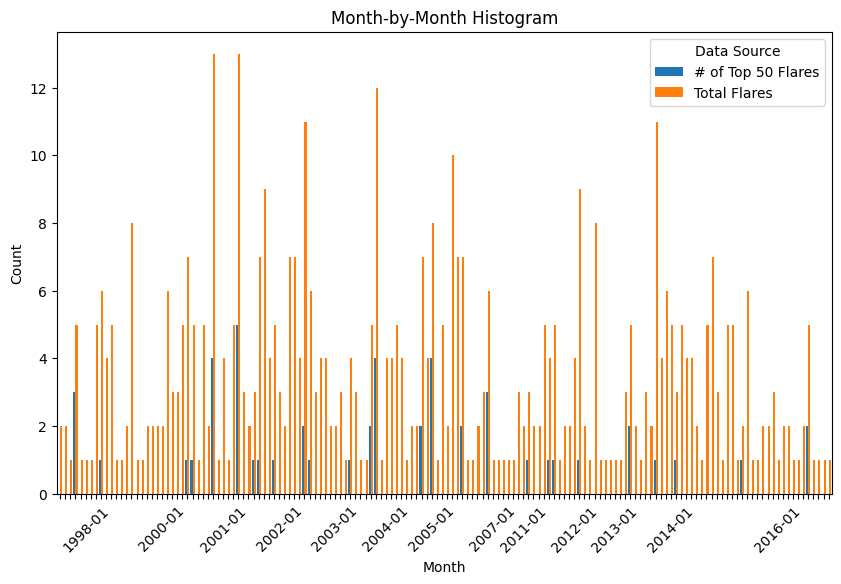

In [ ]:
import matplotlib.pyplot as plt

top_nasa['start_datetime'] = pd.to_datetime(top_nasa['start_datetime'])
nasa_df['start_datetime'] = pd.to_datetime(nasa_df['start_datetime'])

# Group the data by month and count the occurrences
top_nasa['month'] = top_nasa['start_datetime'].dt.strftime('%Y-%m')
nasa_df['month'] = nasa_df['start_datetime'].dt.strftime('%Y-%m')

top_counts = top_nasa['month'].value_counts().sort_index()
tot_counts = nasa_df['month'].value_counts().sort_index()

# Combine the counts into a single DataFrame
combined_counts = pd.concat([top_counts, tot_counts], axis=1, keys=['# of Top 50 Flares', 'Total Flares'])

# Set the index name for the DataFrame
combined_counts.index.name = 'month'

# Sort the index chronologically
combined_counts = combined_counts.sort_index()

# Create the bar plot
ax = combined_counts.plot(kind='bar', width=0.8, figsize=(10, 6))

# Customize the plot
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.set_title('Month-by-Month Histogram')
ax.legend(title='Data Source')

# Label only one month per year with month and year
months = combined_counts.index
ax.set_xticks(range(len(months)))
ax.set_xticklabels([month if month.endswith('-01') else '' for month in months], rotation=45)

# Show the plot
plt.show()

This plot shows the number of flares per month throughout the entire time period, as well as the number of top 50 flares occurring in the same month.  The goal was to examine whether a month with more flares also tended to have more large flares.  According to this graph, that would appear to be the case, as each month with at least one top 50 flare has a spike in total flares.  This would suggest a strong positive covariance between total flares and top 50 flares.